# Natural Language Processing for Twitter Sentiment Analysis

## Patrick Geitner

This notebook contains the code that went into creating the logistic model, data
visualization, and applying the model to individual sentences and paragraphs. Additional code related 
to this project is contained in the `app.py` script which involves making a streamlit dashboard and 
using the Twitter API to scrape tweets from a URL. A formal report for this project can be
in the `Final Project Report.docx` file and the dataset used for this analysis is found in the `training.1600000.processed.noemitcon.csv`
file. The GitHub Repository for this entire project can be found at https://github.com/patgeitner/MA346TwitterSentimentAnalysis.

The **Logistic Model** and **Term Frequency Inverse Document Frequency** techniques used in this study were guided
by the article in the following link: https://towardsdatascience.com/social-media-sentiment-analysis-part-ii-bcacca5aaa39

## Data Preparation 

To begin, we will have to import some packages that will be helpful in preparing the data to be used to 
train a logistic model. The NLTK package will be imported to use the `PorterStemmer` function which strips
the suffixes (es, ing, s, ly, etc.) from words to gain greater meaning from words and make them more useful
in our model

In [ ]:
import re
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import nltk

Now that we have our packages imported, we can read the dataset in from the csv file using Panda's `read_csv` function.
We will also give the columns some relevant names.

In [ ]:
training_df = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding = "ISO-8859-1", engine='python')
training_df.columns = ['sentiment', 'id', 'date', 'query', 'user', 'text']
training_df.head()

,sentiment,id,date,query,user,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


Here, you can see that our dataset was read in with the appropraite names. However, we really only need to 
keep the columns with the tweet text and labeled sentiment, since none of the other columns will be helpful
in our analysis

In [ ]:
df = training_df[['sentiment', 'text']]
df.head()

,sentiment,text
0,0,is upset that he can't update his Facebook by ...
1,0,@Kenichan I dived many times for the ball. Man...
2,0,my whole body feels itchy and like its on fire
3,0,"@nationwideclass no, it's not behaving at all...."
4,0,@Kwesidei not the whole crew


Now that our dataset only contains the columns that we need, we can split the data into training data to 
train our model from, and testing data to see how well our model does in predicting unseen data.

In [ ]:
df = df.sample(50000) # sampling only 50,000 entries because Deepnotes Computing Power can't handle any more
train_entries = np.random.rand(len(df)) < 0.8 
training_df = df[train_entries] # creating a test datframe of the 80% of values 
test_df = df[~train_entries] # creating a test dataframe from the entries not in the training dataframe

The above code takes a sample of 50000 entries from the dataset since that's all that DeepNote can handle,
splits the dataset. The training dataset is made up of 80% of the sample of 50,000 entries, and the test
dataset is made up of 20% of the sample.

### Removing Mentions, Special Characters, and Short Words

Now that we have our training and test datasets, we can now begin manipulating the tweet contents so that we
can extract greater meaning from the text that we have. We will begin with some code to remove twitter
handles from tweets since it won't give us much insight into whether the tweet is positive or negative.

The below function removes patterns from text, we will use this on everything following an @ sign in our dataset.

In [ ]:
def remove_pattern(text,pattern):
    # re.findall() finds all occurences of a pattern and puts them in a list
    r = re.findall(pattern,text)
    # re.sub() removes all instances of the pattern
    for i in r:
        text = re.sub(i,"",text)
    return text

Now that we have that function created to remove patterns, we can use that on our dataset. The below
function removes mentions from all of the tweets. Additionally, it removes any special characters or numbers so 
we're left with only text. Lastly, this function also removes all words that are less than 3 letters since
words like "the", "or", and "and" are common, but don't add much meaning to a sentence.

In [ ]:
def removing_unwanted_elements(dataframe, column_name):
    dataframe["cleaned_tweets"] = np.vectorize(remove_pattern)(dataframe[column_name], "@[\w]*") # removing everything following an @ sign from the tweet
    dataframe['cleaned_tweets'] = dataframe['cleaned_tweets'].str.replace("[^a-zA-Z#]", " ") # replacing all characters that aren't letters or numbers with a space
    dataframe['cleaned_tweets'] = dataframe['cleaned_tweets'].apply(lambda x: ' '.join([word for word in x.split() if len(word)>3])) # removes words shorter than 3 characters

removing_unwanted_elements(training_df, 'text')

/opt/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/venv/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

In [ ]:
training_df.head()

,sentiment,text,cleaned_tweets
300134,0,just arrived @ &quot;inlaws&quot; feel like sh...,just arrived quot inlaws quot feel like shit w...
824863,4,@behemothdan Woot I got shoulders tooooo!,Woot shoulders tooooo
128889,0,I'm heading to work...Monday,heading work Monday
1480404,4,@kristinad75 check this out: http://tweeternet...,check this http tweeternet Might help explain ...
74838,0,One case of swine flu iconfirmed in PA. But he...,case swine iconfirmed been treated hoping that...


Now that we have run the function on the text column of our dataset, we can see that the cleaned tweets column
now contains the tweets without mentions, numbers and special characters, and short words. The next thing
that we can do is remove the suffixes from words. This will mean that words like easy, easier, and easiest
are treated the same in our model.

### Removing Suffixes

To remove the suffixes from the tweets, we have to start by converting the text contained in the `cleaned_tweets` column
to lists of words. We can do this by applying a lambda function that uses the `.split()` method.

In [ ]:
tokenized_tweet = training_df['cleaned_tweets'].apply(lambda x: x.split()) # splitting all entries in the dataset into lists of words
tokenized_tweet.head()

300134     [just, arrived, quot, inlaws, quot, feel, like...
824863                             [Woot, shoulders, tooooo]
128889                               [heading, work, Monday]
1480404    [check, this, http, tweeternet, Might, help, e...
74838      [case, swine, iconfirmed, been, treated, hopin...
Name: cleaned_tweets, dtype: object

Now that each tweet is shown as a list of words, we can use NLTK's PorterStemmer method to remove the suffixes
from the words. We will do this by applying the `PorterStemmer.stem()` on each word using a lambda function.

In [ ]:
from nltk import PorterStemmer # strips suffixes from a word 
ps = PorterStemmer()
tokenized_tweet = tokenized_tweet.apply(lambda x: [ps.stem(i) for i in x]) # applying stemmer function on every word

In [ ]:
tokenized_tweet.head()

300134     [just, arriv, quot, inlaw, quot, feel, like, s...
824863                              [woot, shoulder, tooooo]
128889                                  [head, work, monday]
1480404    [check, thi, http, tweeternet, might, help, ex...
74838      [case, swine, iconfirm, been, treat, hope, tha...
Name: cleaned_tweets, dtype: object

As you can see in the output above, this function stripped away all suffixes from words leaving us with the
root of each word. We will now reset the index of this series so that it is sequential numbers starting at 0.

In [ ]:
tokenized_tweet = tokenized_tweet.reset_index(drop=True)
tokenized_tweet.head()

0    [just, arriv, quot, inlaw, quot, feel, like, s...
1                             [woot, shoulder, tooooo]
2                                 [head, work, monday]
3    [check, thi, http, tweeternet, might, help, ex...
4    [case, swine, iconfirm, been, treat, hope, tha...
Name: cleaned_tweets, dtype: object

As you can see, the result is a series of lists containing the root of the words in each tweet. We will now join these lists
back into strings and add them back to the dataframe to train our model from.

In [ ]:
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])  # rejoining every lists of words into sentences

training_df = training_df.reset_index(drop=True)
training_df['cleaned_tweets'] = tokenized_tweet  # creating cleaned_tweets column from stemmed words
training_df.head()

,sentiment,text,cleaned_tweets
0,0,just arrived @ &quot;inlaws&quot; feel like sh...,just arriv quot inlaw quot feel like shit wann...
1,4,@behemothdan Woot I got shoulders tooooo!,woot shoulder tooooo
2,0,I'm heading to work...Monday,head work monday
3,4,@kristinad75 check this out: http://tweeternet...,check thi http tweeternet might help explain m...
4,0,One case of swine flu iconfirmed in PA. But he...,case swine iconfirm been treat hope that wasn ...


Now, our `cleaned_tweets` column contains only the root for each word so that our model will treat words with the 
same root as the same word.

## Data Visualization

The TowardsDataScience article had some cool data visualization formats so I figured I would try it on this dataset.
the below code makes a word cloud showing which words occurred most frequently in negative and positive
tweets. We start by making a big string of all words from negative tweets.

In [ ]:
negative_words = ' '.join(text for text in training_df['cleaned_tweets'][training_df['sentiment']==0])
negative_words = negative_words.split(" ")

Since we stripped suffixes off the words earlier, our visualizatiosn would look weird if they contained just the 
roots of words. We can turn the words that have been stripped back into a form of the original word by
making a dictionary of all of the stemmed words and using a list comprehension to access the values desired values.

In [ ]:
# creating a dictionary of words to add suffixes back to 
dct = {'sorri':'sorry', 'realli': 'really', 'quot':'quote', 'tire':'tired', 'noth':'nothing', 'alreadi':'already', 'veri': 'very', 'anoth':'another', 'didn':'didnt', 'mayb': 'maybe', 'onli':'only', 'everyth': 'everything', 'becaus': 'because', 'littl':'little', 'doe':'does', 'sinc':'since', 'alway': 'always', 'studi':'studying', 'early': 'early', 'famili': 'family', 'morn': 'morning', 'awesom': 'awesome', 'thi': 'this', 'peopl': 'people', 'didn': 'didnt', 'headach':'headache', 'thank':'thanks', 'comput': 'computer', 'cau':'cause', 'veri': 'very', 'iphon': 'iphone', 'littl':'little', 'mani':'many', 'couldn':'couldnt', 'lime':'test', 'babi':'baby', 'happi':'happy', 'leav':'leave', 'anyth':'anything', 'anymor': 'anymore', 'movi': 'movie', 'seriou':'serious', 'befor': 'before', 'busi': 'busy', 'chang':'change', 'someth':'something', 'tri':'try', 'pleas':'please', 'someon':'someone', 'doesn':'doesnt', 'bore':'bored'}
negative_words = [ dct.get(k, k) for k in negative_words ] # mapping dictionary to negative words, returning the original word if it isn't in the dictionary
negative_words = " ".join(negative_words) # joining back into a string

Now that we have this big string containing the correct form of the words, we can use the wordcloud package to create a wordcloud over the Twitter logo
to give us a cool visualization. We can start by imposing an image of the Twitter logo over the word cloud.
We can then extract the colors from the image to use as our text colors. Then we can use the `WordCloud` 
function to generate a word cloud. The `interpolation="hamming"` argument is used to smooth the edges of the 
text to make it look good.

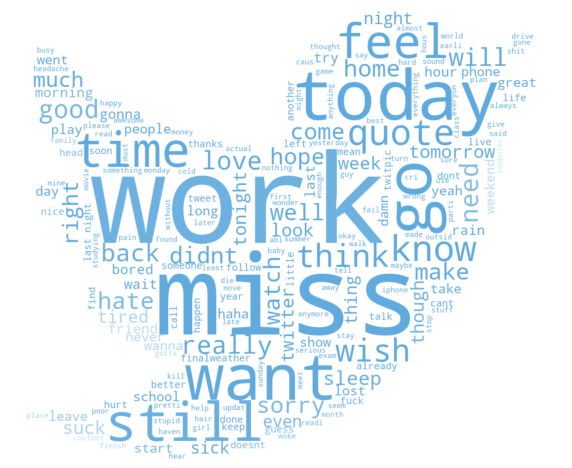

In [ ]:
from wordcloud import WordCloud,ImageColorGenerator
from PIL import Image
import urllib
import requests

image = np.array(Image.open(requests.get('http://clipart-library.com/image_gallery2/Twitter-PNG-Image.png', stream=True).raw)) # putting the image over the wordcloud
colors = ImageColorGenerator(image)
wc = WordCloud(background_color='white', height=1500, width=4000,mask=image).generate(negative_words) # making the word cloud
plt.figure(figsize=(10,20)) # setting the size
plt.imshow(wc.recolor(color_func=colors),interpolation="hamming") # recoloring the words to match the image and smoothing the edges 

plt.axis('off')
plt.show()

The above output shows the most frequently occurring words in negative tweets. You can see that words like work, miss, sad, and 
want are all used frequently. We can repeat this process for the positive tweets.

Once again, we start by making a big string of all words contained in positive tweets.

In [ ]:
positive_words = ' '.join(text for text in training_df['cleaned_tweets'][training_df['sentiment']==4])
positive_words = positive_words.split(" ")

We also repeat the same process to avoid having stemmed words in our visualization. We will create a dictionary
of words that have been stemmed and use a list comprehension to map them to the desired words.

In [ ]:
# creating a dictionary of words to add suffixes back to 
dct2 = {'sorri':'sorry', 'realli': 'really', 'quot':'quote', 'tire':'tired', 'noth':'nothing', 'alreadi':'already', 'veri': 'very', 'anoth':'another', 'didn':'didnt', 'mayb': 'maybe', 'onli':'only', 'everyth': 'everything', 'becaus': 'because', 'littl':'little', 'doe':'does', 'sinc':'since', 'alway': 'always', 'studi':'studying', 'early': 'early', 'famili': 'family', 'morn': 'morning', 'awesom': 'awesome', 'thi': 'this', 'peopl': 'people', 'didn': 'didnt', 'headach':'headache', 'thank':'thanks', 'comput': 'computer', 'cau':'cause', 'veri': 'very', 'iphon': 'iphone', 'littl':'little', 'mani':'many', 'couldn':'couldnt', 'lime':'test', 'babi':'baby', 'happi':'happy', 'leav':'leave', 'anyth':'anything', 'anymor': 'anymore', 'movi': 'movie', 'seriou':'serious', 'befor': 'before', 'busi': 'busy', 'chang':'change', 'someth':'something', 'tri':'try', 'pleas':'please', 'someon':'someone', 'doesn':'doesnt', 'bore':'bored', 'excit': 'exciting', 'amaz':'amazing', 'parti':'party','rememb':'remember', 'welcom': 'welcome', 'funni':'funny', 'readi':'ready','beauti':'beauty', 'pictur':'picture', 'earli': 'early', 'pretti':'pretty'}
positive_words = [ dct2.get(k, k) for k in positive_words ] # mapping dictionary to positive words, returning the original word if it isn't in the dictionary
positive_words = " ".join(positive_words) # joining back into a string

We can use this big string  to make another wordcloud over the Twitter logo to show us the most used words
in positive tweets. We will use the same process that we did for the negative words above.

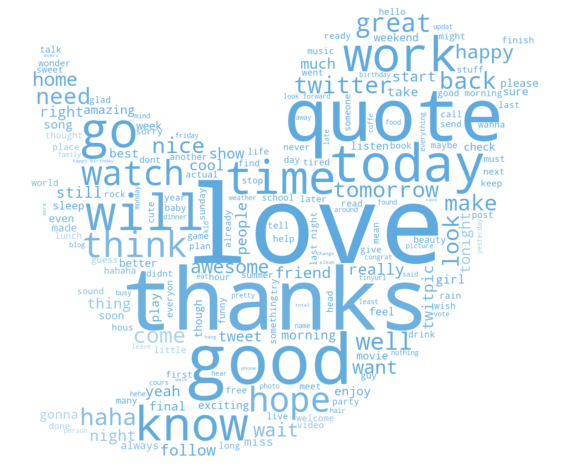

In [ ]:
wc = WordCloud(background_color='white', height=1500, width=4000,mask=image).generate(positive_words) # putting the image over the word cloud
plt.figure(figsize=(10,20)) # setting the size of the image
plt.imshow(wc.recolor(color_func=colors),interpolation="hamming") # making the text color match the image color and smoothing the edges

plt.axis('off')
plt.show()

The above output shows that words like thank, love, good, and lol, are the most frequently used words in positive tweets.
This makes sense because these are all pretty positive words!

## Modeling Preparation

Now that we have looked at some visuals for our dataset and the positive and negative values make sense, we can 
get our data in the format needed to apply a logistic model. First, we will represent positive tweets
with the value `1`, in the original dataset they used `4`, so we will use the `.replace` method to change
all of the 4s in the dataset to 1s.

In [ ]:
# replacing all 4s with 1s to denote positive sentiment
training_df = training_df.replace(to_replace=4, value=1) 
test_df = test_df.replace(to_replace=4, value=1)
test_df = test_df.reset_index(drop=True) # resetting the index of the test dataframe since its jumbled from the sampling

Now that we have the `sentiment` columns of both the training and test datasets containing 0s and 1s,
we are ready to vectorize our data which will allow us to fit a logistic model to our data. For this 
study, we will be using a method called **Term Frequency Inverse Document Frequency**. This is a method for
extracting meaning from a dataset of words by scoring each word's relevance. This is done by multiplying how 
many times a a word shows up in an entry and the inverse document frequency of a word across a set of entries.
This will allow us to determine how important a word is in influencing whether a tweet is positive or 
negative while accounting for words that are common in all tweets.

### Term Frequency Inverse Document Frequency (TF-IDF)

We can using `sklearn`'s `TfidfVectorizer` function to easily create a TF-IDF vector of our data that we will
need to fit a logistic model to it. We use the argument `stop_words='english'` which tells the function to automatically
ignore words like "the", "and", and "him" that don't add significant meaning to text.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_df=0.90, min_df=2,max_features=1000,stop_words='english') # initializing the vectorizer
tfidf_matrix = tfidf.fit_transform(training_df['cleaned_tweets']) # fitting the vectorizer to the cleaned_tweets column 
train_tfidf_matrix = tfidf_matrix[:50000].todense() # making sure our matrix is in the right shape for the data we are using 
df_tfidf = pd.DataFrame(tfidf_matrix)
df_tfidf

,0
0,"(0, 949)\t0.3381582708392784\n (0, 764)\t0...."
1,
2,"(0, 576)\t0.6668504993182393\n (0, 983)\t0...."
3,"(0, 302)\t0.623572164018445\n (0, 422)\t0.4..."
4,"(0, 375)\t0.3585081557478649\n (0, 953)\t0...."
...,...
39933,"(0, 996)\t0.5941673651155717\n (0, 892)\t0...."
39934,"(0, 253)\t0.38583792235182574\n (0, 56)\t0...."
39935,"(0, 679)\t1.0"
39936,"(0, 690)\t0.44096060630191014\n (0, 964)\t0..."


As you can see in the output above, we created a TF-IDF vector of our data. We used the `.DataFrame()` method
to make a dataframe from the matrix that we created using the `.todense()` method. Now that we have a TF-IDF
matrix of all our data, we can split it into training and validation data. To do this, we start by taking by running
a train test split using `sklearn's` `train_test_split` function.

### Splitting into Training and Testing Dataframes

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
x_train_tfidf, x_valid_tfidf, y_train_tfidf, y_valid_tfidf = train_test_split(train_tfidf_matrix,training_df['sentiment'],test_size=0.3,random_state=17)

This function splits the the data that we are using for the model into 70% training data and 30% validation data.
Now that we have separated our training data, which will be used to make the model, and our validation data, which
will be used to ensure our model is working properly before trying it on our test data, we can apply a machine 
learning model to fit our data. We will begin this by importing the necessary packages from `sklearn`.

## Applying Machine Learning Model

In [ ]:
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression

Now that we have imported the packages to fit the logistic regression and for computing the model's F1 score,
We can use our training data to train the model. We will start by initializing our Logistic Regression model
and fitting it to our training data. We will then use the `model.predict_proba()` function to test our model
on the validation data to see how accurate our model is .

### Logistic Model Using TD-IDF

In [ ]:
model = LogisticRegression(random_state=0,solver='lbfgs') # intitializing the model
model.fit(x_train_tfidf, y_train_tfidf) # fitting the model to the training data
prediction_tfidf = model.predict_proba(x_valid_tfidf) # using the model to predict on validation data
prediction_int = prediction_tfidf[:,1]>=0.5 # classifying as positive if predicted probability > .5
prediction_int = prediction_int.astype(np.int) # changing boolean value to 0s and 1s
prediction_int


array([1, 1, 1, ..., 1, 1, 0])

The above outpur shows an array of our model's predictions for the validation data. We can use the `f1_score` function
to compute the F1 score of our model on the validation data. An F1 score is a way of computing the quality of 
a classification model. It is computed by taking the weighted average of **Precision** and **Recall** where
precision is essentially the odds that a predicted positive is a true positive and recall is essentially
the odds that the model detects a true positive.

In [ ]:
# Calculating f1 score
train_f1_score = f1_score(y_valid_tfidf, prediction_int)
train_f1_score

0.7324147933284989

As you can see in the above output, the F1 score of our model when testing it on the validation data
is about .731. With that being said, it looks like our model is working pretty well, so we can continue by testing
our model on the unseen data that we separated out at the beginning of the study. This gives us a better idea
of how applicable our model is. We can start to do this by creating a TF-IDF matrix of the test data.

### Testing Model on Unseen Data

In [ ]:
tfidf_test_matrix = tfidf.fit_transform(test_df['text']) # creating a TF-IDF matrix of test data
df_tfidf_test = pd.DataFrame(tfidf_test_matrix.todense()) # converting to dataframe for visualization
df_tfidf_test

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10057,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
10058,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.364839,0.0,0.0,0.0,0.0,0.0,0.0
10059,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
10060,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


The output above shows that we have created a TF-IDF matrix of the `text` column of the test data and displayed
it as a dataframe. Now that this is done, we can apply the model and add our model's prediction as a new column
on the test dataframe.

In [ ]:
test_pred = model.predict_proba(tfidf_test_matrix) # applying our model to the test data
test_pred_int = test_pred[:,1] >= 0.5 # labeling prediction as 1 if probability is more than half
test_pred_int = test_pred_int.astype(np.int) # changing the boolean prediction to to original format of 1s and 0s

test_df['prediction'] = test_pred_int # creating a new column of predictions
test_df

,sentiment,text,prediction
0,1,@teetee31 Am feeling grand hun just a wee bit ...,1
1,0,The pens are failing.,1
2,1,my little tweets have been pretty silent today...,0
3,1,@Its_Claire morning to you too,0
4,0,@Stephanya Sold! lol. Does this look painful? ...,0
...,...,...,...
10057,0,@airlanggatwerp eww i miss to see them lg ape...,0
10058,0,"well, life isn't that nice after all hope it...",0
10059,1,"beat dis yesterday, with audrey - got the thir...",0
10060,0,"hi, my name is lauren. I think I'm cool but I'...",0


As you can see, the above output shows us that we have successfully applied our model to the test data
and the predictions are stored in the new `prediction` column. Now that we have our predictions, we can calculate
F1 score again to see how well our model did on this new data. This time we will do this by calculating
precision and recall on our own using true positives, true negatives, false positives, and false negatives, and then
taking the weighted average between precision and recall.

In [ ]:
TP = ( test_df['sentiment'] & test_df['prediction'] ).sum() # true positives
TN = ( ~test_df['sentiment'] & ~test_df['prediction'] ).sum() # true negatives
FP = ( ~test_df['sentiment'] & test_df['prediction'] ).sum() # false positives
FN = ( test_df['sentiment'] & ~test_df['prediction'] ).sum() # false negatives

# Precision and recall are defined using the formulas above.
precision = TP / ( TP + FP )
recall = TP / ( TP + FN )
F1 = 2 * precision * recall / ( precision + recall )
F1

0.49515215513103583

The output above shows that the F1 score of our model on the unseen test data is approximately .52. While this is 
quite a bit less than the F1 score we saw earlier, that is to be expected because this data has never been seen 
before. However, I think if we were able to train the model on more than 40,000 entries, we would get a better
F1 score and have a model that makes better predictions! Because of this, when making the application for the model
I will use all 1.6 million tweets to train the model so that it is as accurate as possible.

Now that we have confirmed that the model works sufficiently well, we can create a function that makes an
individual prediction for a string of text. This will be the basis for the application for this project
in that it will allow the user to enter some text and classify the text as either positive or negative. We 
can do this by transforming the user's text to a TF-IDF matrix and using the `model.predict_proba()` method
to get the individual prediction. 

In [ ]:
def individual_pred(text):
    tfidf_test_matrix = tfidf.transform([text]) # creating TF-IDF matrix from entered text
    test_pred = model.predict_proba(tfidf_test_matrix) # appplying model to predict probability
    test_pred_int = test_pred[:,1] >= 0.5 # classifying as positive if probability > .5
    test_pred_int = test_pred_int.astype(np.int) # chagning predition to 0 (negative) or 1 (positive)
    return test_pred_int[0]

individual_pred("I alone cannot change the world, but I can cast a stone across the water to create many ripples.")

1

As you can see, our model classifies the above quote as positive. The code for creating the application
using a larger version of this model can be found in the app.py file in this project. In this file we allow
the user to enter some text like the above example, or the URL to an actual Twitter post and display the prediction
as well as the sentiment of each word in the string of text.